Import the libraries necessary to analize data

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('df_scaled.csv')

Since we use distance metric working on numerical features we remove the categorical data and useless features 

In [3]:
column_to_drop = ['avg_age_participants','n_participants','n_participants_child', 'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'isKilled', 'involve_injury','pc1', 'pc2']

for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['avg_age_participants',
 'n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'isKilled',
 'involve_injury',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [4]:
df_categorical = df[column_to_drop].copy()
df_numeric = df.drop(columns=column_to_drop)

In [5]:
df_categorical.info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   avg_age_participants       166664 non-null  float64
 1   n_participants             166664 non-null  float64
 2   n_participants_child       166664 non-null  int64  
 3   n_participants_teen        166664 non-null  int64  
 4   n_females                  166664 non-null  float64
 5   n_killed                   166664 non-null  float64
 6   n_injured                  166664 non-null  float64
 7   n_arrested                 166664 non-null  float64
 8   n_unharmed                 166664 non-null  float64
 9   date                       166664 non-null  object 
 10  latitude                   166664 non-null  float64
 11  longitude                  166664 non-null  float64
 12  congressional_district     166664 non-null  int64  
 13  candidatevotes             16

# K-means

In [49]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score

Knee Method to estimate the best K. 

We performed a nested grid search on k.

In [31]:
k_grid = [2, 3, 4, 10, 100, 1000]

sse_list = list()

label_list = []
dict_kmeans = {}
#search for the best k
for k in k_grid:

    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_numeric)
    
    sse = kmeans.inertia_
    labels = kmeans.labels_
    #we save a list of see and labels for each k-means tried
    dict_kmeans[f'{k}_sse'] = sse
    dict_kmeans[f'{k}_labels'] = labels

    print(f'k: {k}, SSE: {sse}')


k: 2, SSE: 1646704.8754374427
k: 3, SSE: 1366709.6190671802
k: 4, SSE: 1208515.0384513792
k: 10, SSE: 832875.8319438391
k: 100, SSE: 289769.5750204325
k: 1000, SSE: 87637.38882029489


In [32]:
for k in k_grid:
    print(f'for k = {k}')
    
    print('SSE %s' % dict_kmeans[f'{k}_sse'])
    current_bouldin = metrics.davies_bouldin_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_bouldin_score'] = current_bouldin
    print('Separation %s' % current_bouldin)
    
    current_silhouette = silhouette_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_silhouette_score'] = current_silhouette
    print('Silhouette %s' % current_silhouette)

for k = 2
SSE 1646704.8754374427
Separation 1.9813490226692585
Silhouette 0.19903279722963033
for k = 3
SSE 1366709.6190671802
Separation 1.5838954094680056
Silhouette 0.2543040652371257
for k = 4
SSE 1208515.0384513792
Separation 1.373537915972873
Silhouette 0.264056508390661
for k = 10
SSE 832875.8319438391
Separation 1.492059625402054
Silhouette 0.26313048361326374
for k = 100
SSE 289769.5750204325
Separation 1.3249339566946525
Silhouette 0.24484177046223854
for k = 1000
SSE 87637.38882029489
Separation 1.239347513960958
Silhouette 0.28485631292038815


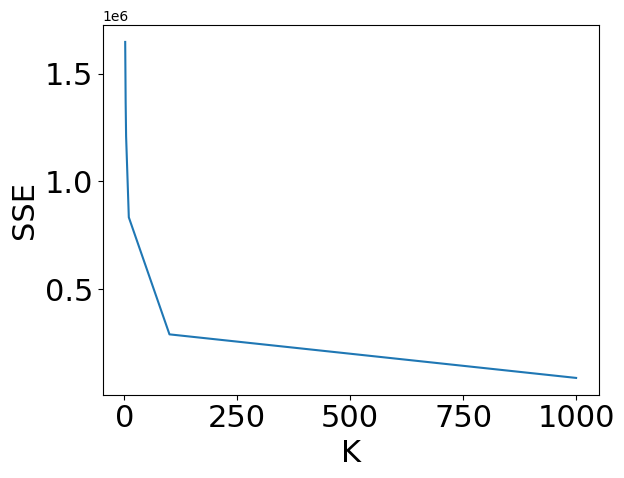

In [33]:
sse_list = [dict_kmeans[f'{k}_sse'] for k in k_grid]
plt.plot(k_grid,sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

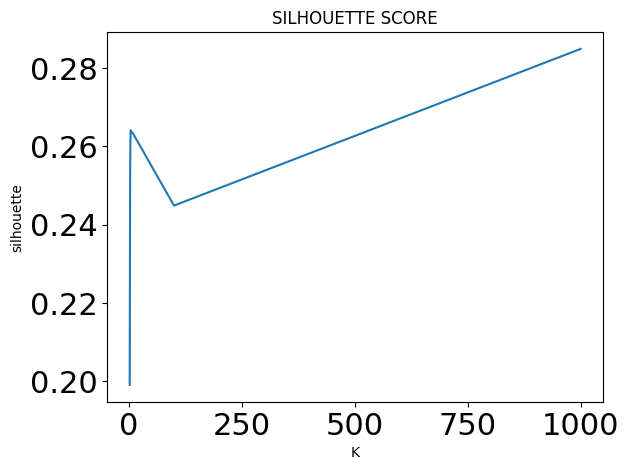

In [34]:
silhouette_list = [dict_kmeans[f'{k}_silhouette_score'] for k in k_grid]
plt.plot(k_grid, silhouette_list)
plt.ylabel('silhouette')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('SILHOUETTE SCORE')
#plt.axvline(6)
plt.show()

From both elbow method and silhouette score, best K is around 4.

In [58]:
#RETRAIN BEST K-MEANS
best_k = 4
best_kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=100)
best_kmeans.fit(df_numeric)

KMeans(max_iter=100, n_clusters=4, n_init=10)

In [59]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(best_kmeans.labels_ == k))

print('cluster sizes:', occ_list)

cluster sizes: [33382, 66829, 26607, 39846]


Plotting the result of the clustering on the pca dimensions (pc1 and pc2), labelling each point by the cluster label

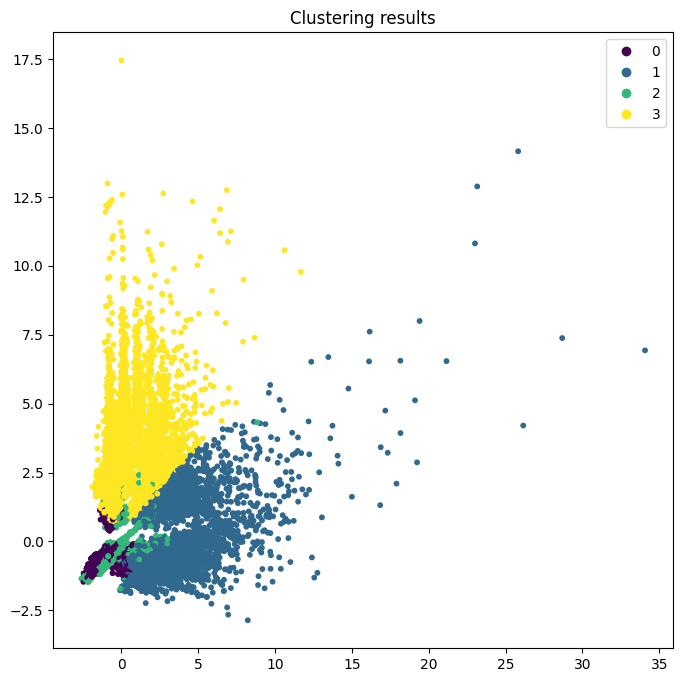

In [21]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(df['pc1'], df['pc2'], c=best_kmeans.labels_, s=10)

plt.tick_params(axis='both', which='major')
plt.title("Clustering results")
plt.legend(*scatter.legend_elements())

Plot of cluster labels distribution

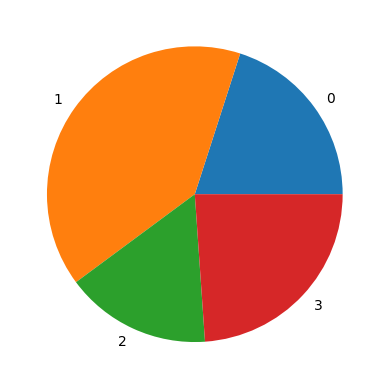

In [22]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

Involve_killing or not distribution

As we can see the number of killed persons in 2 out of 3 clusters is 0.

Radiant plot

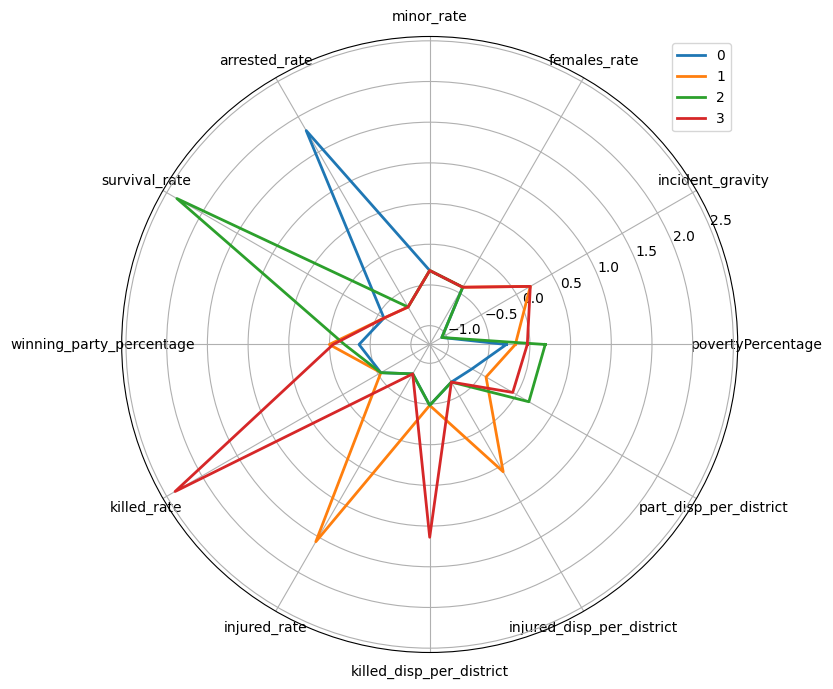

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import math

N = len(df_numeric.columns)
plt.figure(figsize=(8, 8))



for k in range(0, n_clusters):
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
     
    values = df_numeric[best_kmeans.labels_ == k].median().values.tolist()
    
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], df_numeric.columns)
    ax.plot(angles, values, linewidth=2)


plt.legend(labels=np.unique(best_kmeans.labels_))

plt.show()


Line plot

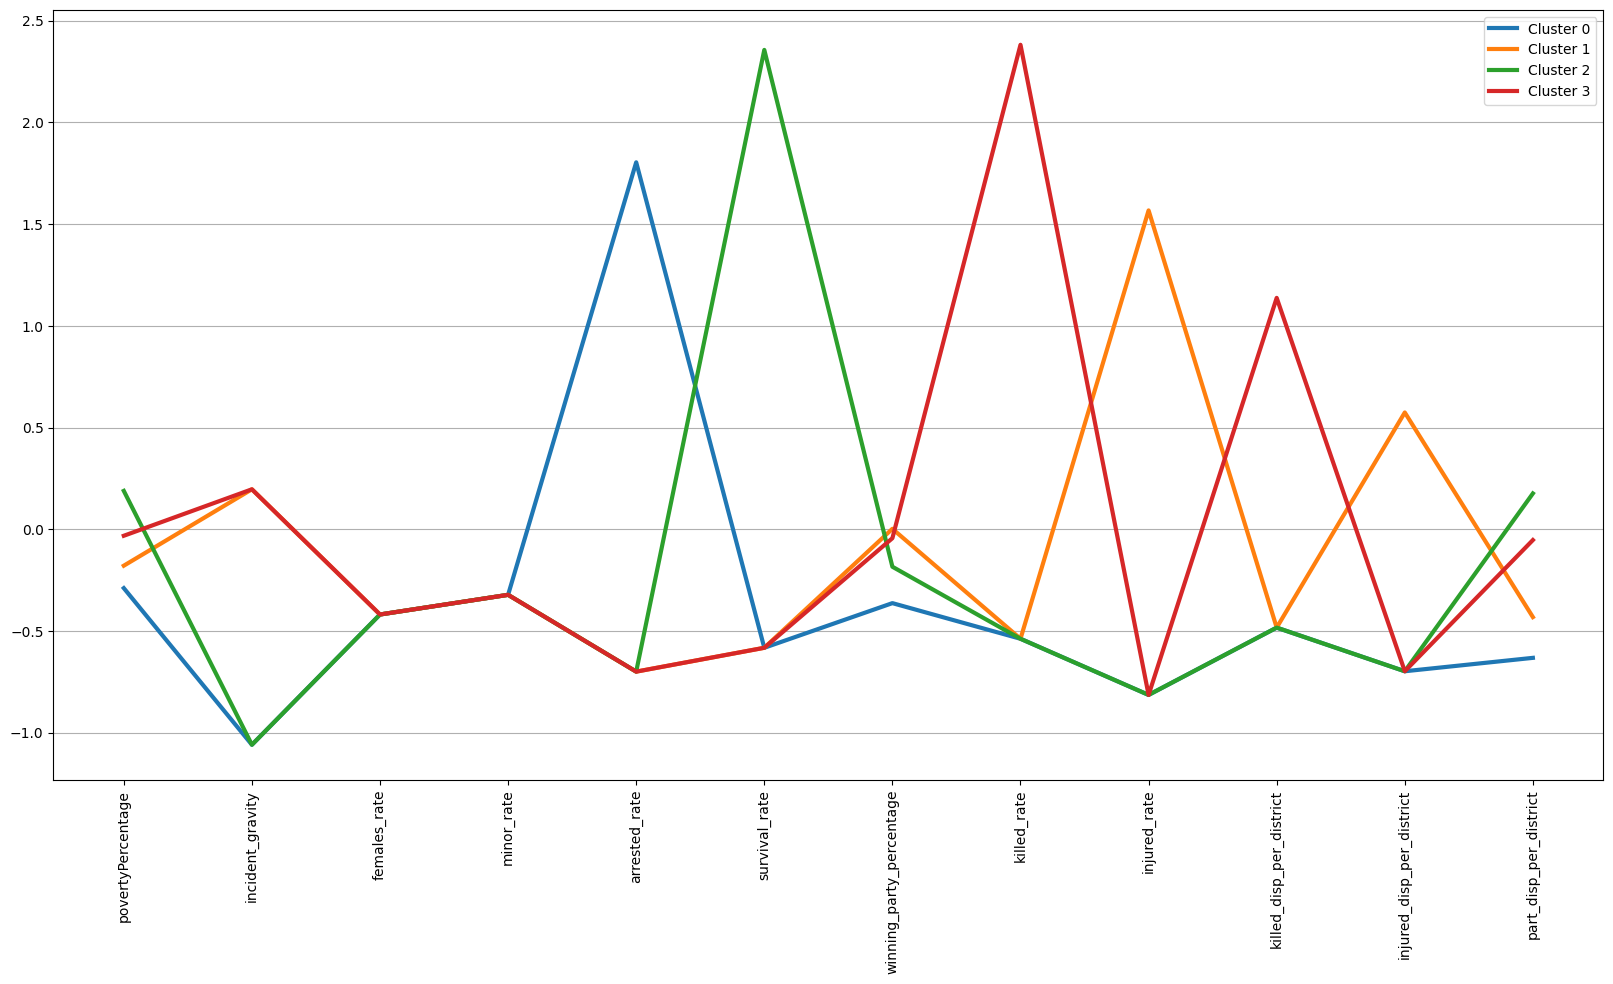

In [27]:
plt.figure(figsize=(20, 10))

for label in np.unique(best_kmeans.labels_):
    cent = df_numeric[best_kmeans.labels_ == label].median()
    plt.plot(cent, label="Cluster %s" % label, linewidth=3)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(df_numeric.columns)), df_numeric.columns, rotation=90)
plt.legend()
plt.gca().yaxis.grid(True)

plt.show()

## Characterizing clusters with cities

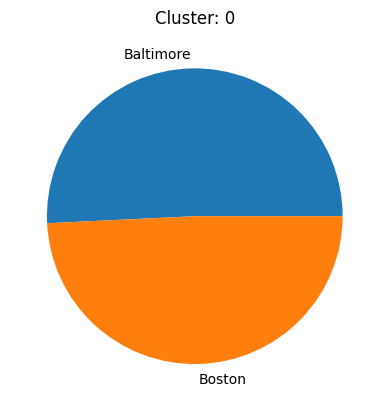

city_or_county
Baltimore    601
Boston       583
Name: count, dtype: int64


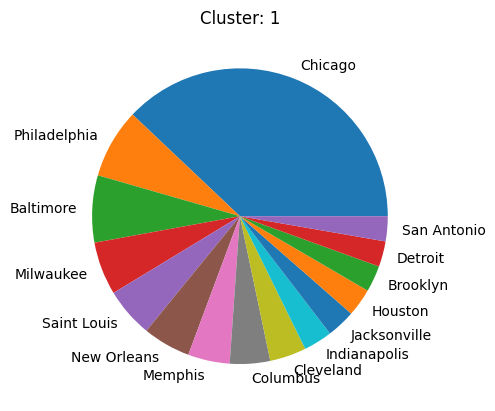

city_or_county
Chicago         7031
Philadelphia    1409
Baltimore       1359
Milwaukee       1077
Saint Louis     1005
New Orleans      967
Memphis          847
Columbus         816
Cleveland        738
Indianapolis     582
Jacksonville     581
Houston          565
Brooklyn         533
Detroit          516
San Antonio      507
Name: count, dtype: int64


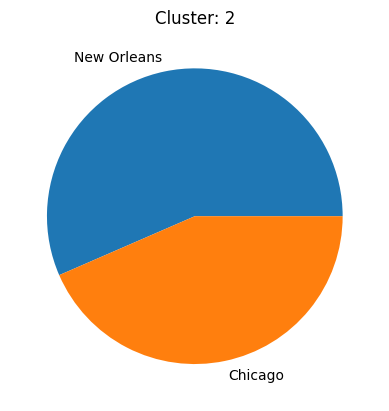

city_or_county
New Orleans    719
Chicago        553
Name: count, dtype: int64


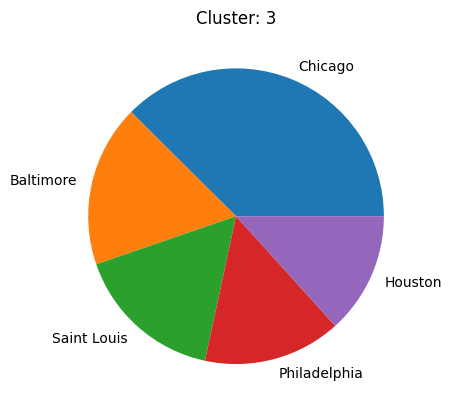

city_or_county
Chicago         1634
Baltimore        770
Saint Louis      711
Philadelphia     656
Houston          578
Name: count, dtype: int64


In [30]:
for k in range(0, n_clusters):
    # Get 'bot' values for elems in cluster k
    injury_for_clust = df_categorical['city_or_county'].loc[best_kmeans.labels_ == k].value_counts() 
    injury_for_clust = injury_for_clust[injury_for_clust > 500]
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(injury_for_clust, labels= injury_for_clust.index)
    plt.show()
    print(injury_for_clust)

##  Characterizing clusters with incident char

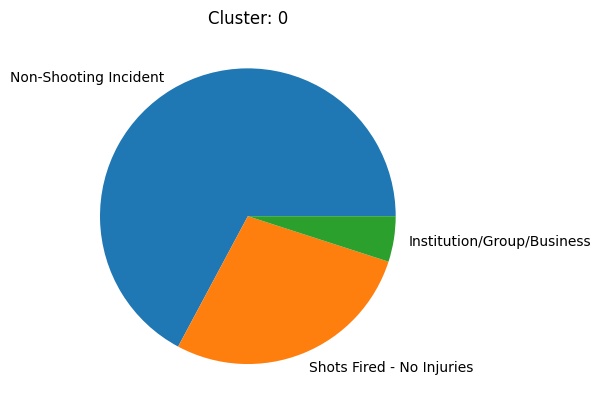

incident_characteristics1
Non-Shooting Incident         21032
Shots Fired - No Injuries      8715
Institution/Group/Business     1558
Name: count, dtype: int64


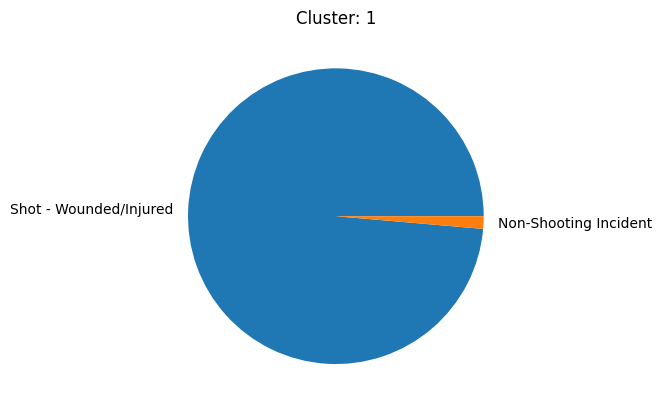

incident_characteristics1
Shot - Wounded/Injured    64877
Non-Shooting Incident       901
Name: count, dtype: int64


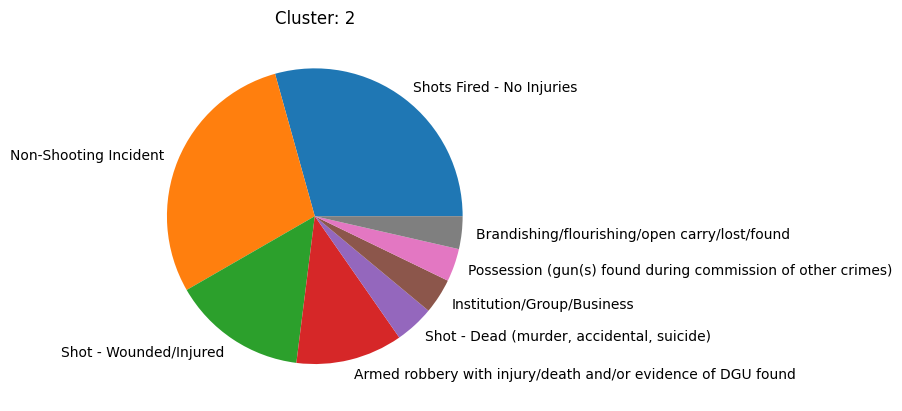

incident_characteristics1
Shots Fired - No Injuries                                       6907
Non-Shooting Incident                                           6825
Shot - Wounded/Injured                                          3460
Armed robbery with injury/death and/or evidence of DGU found    2748
Shot - Dead (murder, accidental, suicide)                       1008
Institution/Group/Business                                       908
Possession (gun(s) found during commission of other crimes)      849
Brandishing/flourishing/open carry/lost/found                    842
Name: count, dtype: int64


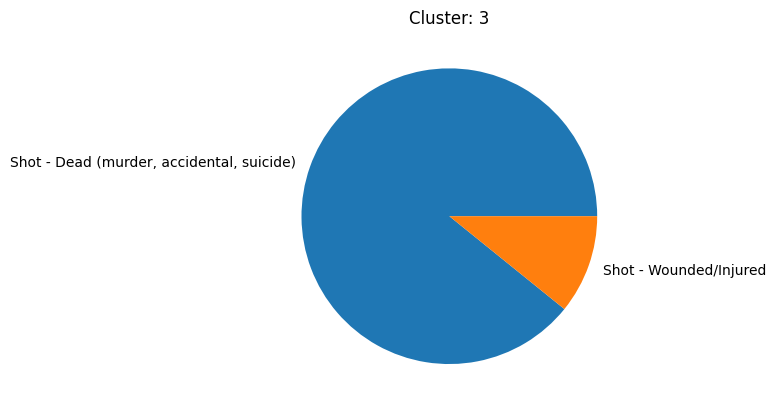

incident_characteristics1
Shot - Dead (murder, accidental, suicide)    35291
Shot - Wounded/Injured                        4277
Name: count, dtype: int64


In [32]:
for k in range(0, n_clusters):
    # Get 'bot' values for elems in cluster k
    injury_for_clust = df_categorical['incident_characteristics1'].loc[best_kmeans.labels_ == k].value_counts() 
    injury_for_clust = injury_for_clust[injury_for_clust > 800]
    # Show pie plot
    labels = ['not-injured', 'injured']
    plt.title('Cluster: ' + str(k))
    plt.pie(injury_for_clust, labels= injury_for_clust.index)
    plt.show()
    print(injury_for_clust)

## Characterizing clusters with arrested, unharmed, killing, injuried

In [60]:
df_task_1 = pd.read_csv('../TASK1/df_after_dp.csv')

In [61]:
df_categorical.loc[df_task_1['n_arrested'] > 0, 'involve_arrest'] = 1
df_categorical.loc[df_task_1['n_arrested'] == 0, 'involve_arrest'] = 0

df_categorical.loc[df_task_1['n_unharmed'] > 0, 'involve_unharmed'] = 1
df_categorical.loc[df_task_1['n_unharmed'] == 0, 'involve_unharmed'] = 0

In [62]:
color_map = {0: 'royalblue', 1: 'darkslategrey'}

def get_colors(data):
    return [color_map[val] for val in data.index]

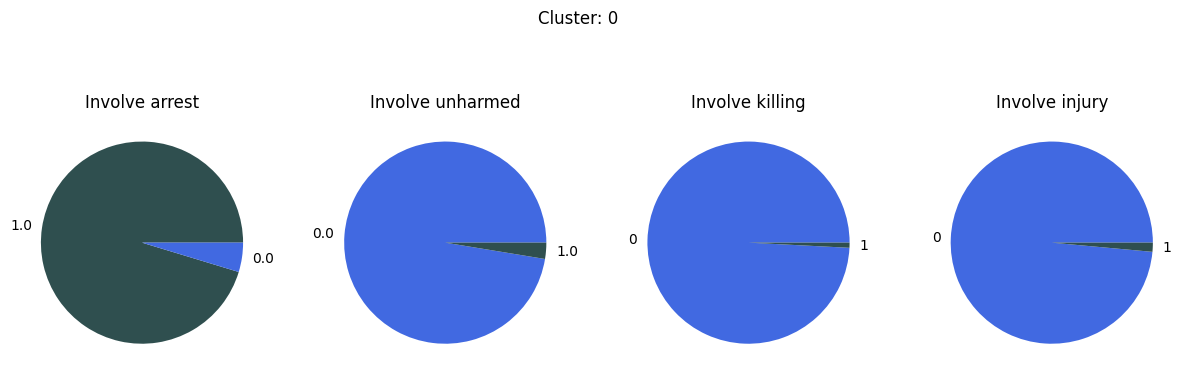

involve_arrest
1.0    31817
0.0     1565
Name: count, dtype: int64

involve_unharmed
0.0    32519
1.0      863
Name: count, dtype: int64

isKilled
0    33110
1      272
Name: count, dtype: int64

involve_injury
0    32897
1      485
Name: count, dtype: int64


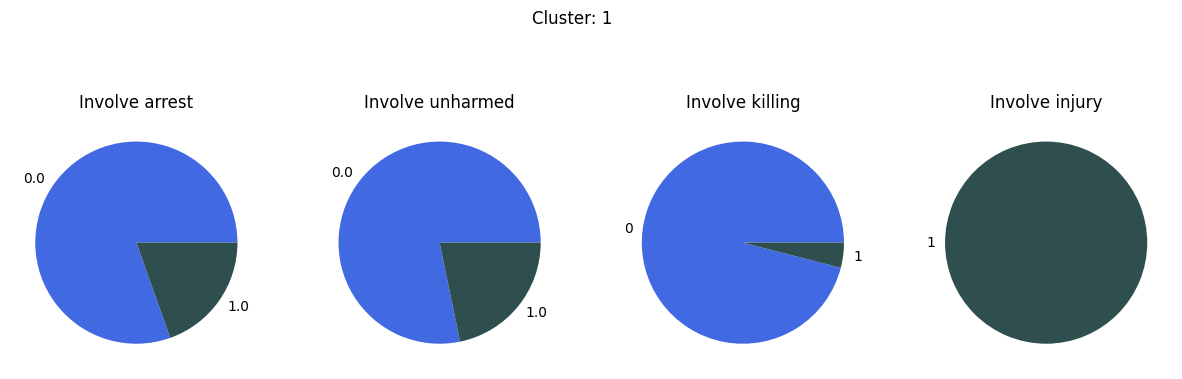

involve_arrest
0.0    53759
1.0    13070
Name: count, dtype: int64

involve_unharmed
0.0    52286
1.0    14543
Name: count, dtype: int64

isKilled
0    64151
1     2678
Name: count, dtype: int64

involve_injury
1    66829
Name: count, dtype: int64


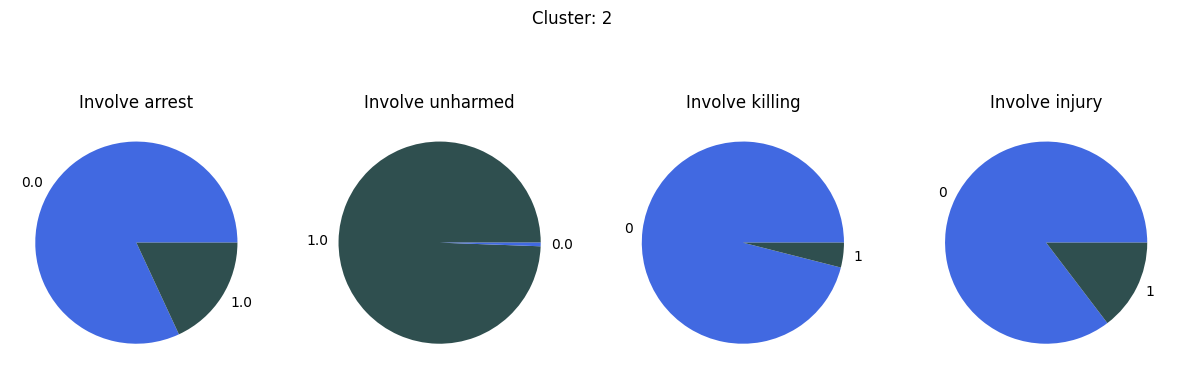

involve_arrest
0.0    21796
1.0     4811
Name: count, dtype: int64

involve_unharmed
1.0    26454
0.0      153
Name: count, dtype: int64

isKilled
0    25553
1     1054
Name: count, dtype: int64

involve_injury
0    22710
1     3897
Name: count, dtype: int64


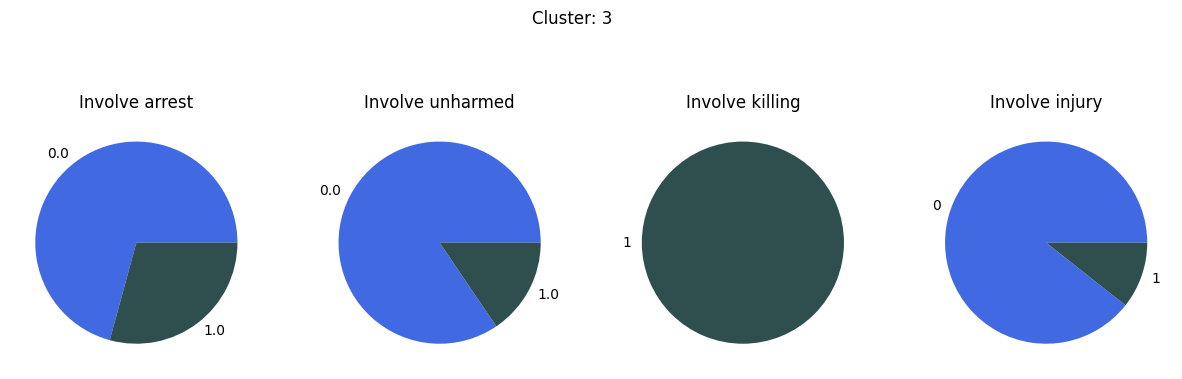

involve_arrest
0.0    28195
1.0    11651
Name: count, dtype: int64

involve_unharmed
0.0    33661
1.0     6185
Name: count, dtype: int64

isKilled
1    39846
Name: count, dtype: int64

involve_injury
0    35608
1     4238
Name: count, dtype: int64


In [63]:

for k in range(0, n_clusters):
    # Get 'bot' values for elems in cluster k
    
    n_arrested_clust =  df_categorical["involve_arrest"].loc[best_kmeans.labels_ == k].value_counts()
    n_unharmed_clust = df_categorical['involve_unharmed'].loc[best_kmeans.labels_  == k].value_counts() 
    n_killed_clust = df_categorical['isKilled'].loc[best_kmeans.labels_ == k].value_counts()
    n_injured_clust = df_categorical['involve_injury'].loc[best_kmeans.labels_ == k].value_counts()

    #showing the two pie plots together
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.suptitle('Cluster: ' + str(k))
    fig.set_figwidth(15)
    ax1.pie(n_arrested_clust, labels= n_arrested_clust.index, colors=get_colors(n_arrested_clust))
    ax2.pie(n_unharmed_clust, labels= n_unharmed_clust.index, colors=get_colors(n_unharmed_clust))
    ax3.pie(n_killed_clust, labels= n_killed_clust.index, colors=get_colors(n_killed_clust))
    ax4.pie(n_injured_clust, labels= n_injured_clust.index, colors=get_colors(n_injured_clust))

    #adding ax1 and ax2 titles
    ax1.set_title('Involve arrest')
    ax2.set_title('Involve unharmed')
    ax3.set_title('Involve killing')
    ax4.set_title('Involve injury')

    #change the colors of the pie plots
    

    plt.show()

    print(n_arrested_clust)
    print()
    print(n_unharmed_clust)
    print()
    print(n_killed_clust)
    print()
    print(n_injured_clust)


# X Means 
#### from: https://github.com/annoviko/pyclustering/

In [23]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn import metrics
from sklearn.metrics import silhouette_score

In [33]:
start_centroids = 4
start_clusters = kmeans_plusplus_initializer(df_numeric, start_centroids, random_state=42).initialize()
 
x_means = xmeans(df_numeric, start_clusters, tolerance=1e-6, kmax=10, repeat=10, random_state=42)
x_means.process()
 
# Clustering results:
print(f'Number of clusters found:', np.shape(x_means.get_centers())[0])
print("SSE:", x_means.get_total_wce())

Number of clusters found: 10
SSE: 875505.8809248749


In [34]:
labels = {}
clusters = x_means.get_clusters()
n_clusters = np.shape(clusters)[0]
#transforming each cluster list from [[cluster1 m points], ...., [clustern p points]] to [[1,1,,....,1 m times], [n,....,n p times]] 
#to {point1:labelcluster1,...., pointm:labelcluster1, ....., point1:labelclustern, ...., pointp:labelclustern} sorted by number of example.
for cluster_label in range(0, n_clusters):
  for i in range(0, len(clusters[cluster_label])):
      labels[clusters[cluster_label][i]] = cluster_label

labels = dict(sorted(labels.items()))
xmeans_labels = list(labels.values())

/Users/lau/Library/Python/3.11/lib/python/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [35]:
print('Separation %s' % metrics.davies_bouldin_score(df_numeric, xmeans_labels)) # lower value, better clustering (minimum zero)
print('Silhouette %s' % silhouette_score(df_numeric, xmeans_labels))

Separation 1.5469668353702986
Silhouette 0.2876653599956561


In [25]:
# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(np.array(xmeans_labels) == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [29714, 4748, 30612, 5613, 10647, 1940, 21532, 26265, 10734, 24859]


Plot of cluster labels distribution

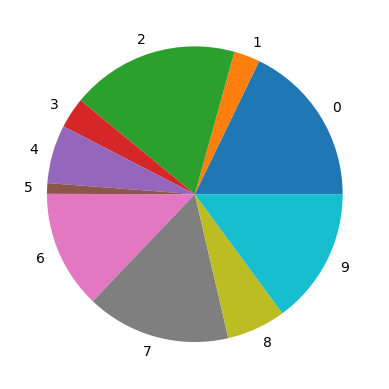

In [26]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show() 

We can see from distribution that the number of records are not really well distributed, we will probably test more and see what happens later.

Involve_killing or not distribution

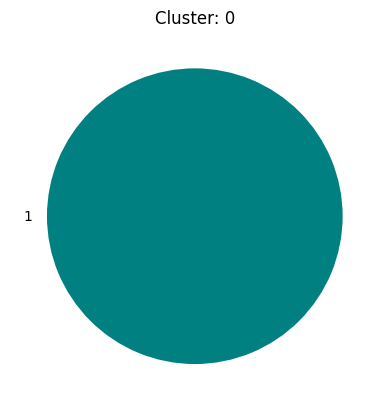

involve_killing
1    29411
Name: count, dtype: int64


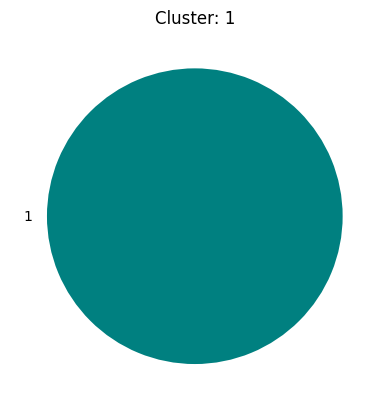

involve_killing
1    12321
Name: count, dtype: int64


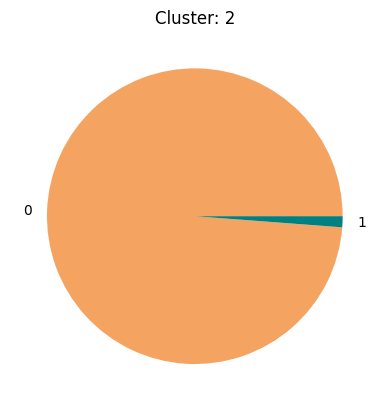

involve_killing
0    24936
1      303
Name: count, dtype: int64


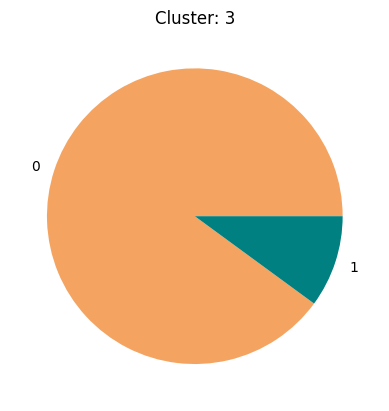

involve_killing
0    5712
1     639
Name: count, dtype: int64


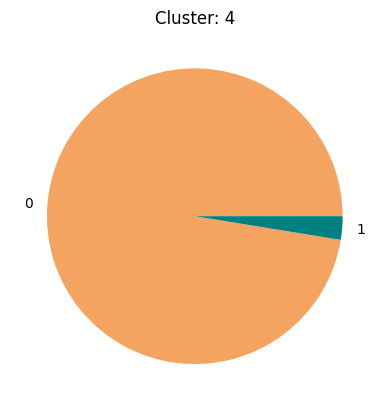

involve_killing
0    16905
1      444
Name: count, dtype: int64


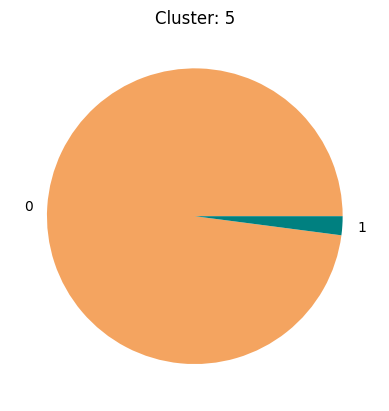

involve_killing
0    16095
1      339
Name: count, dtype: int64


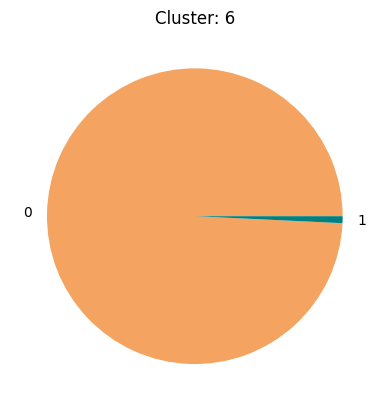

involve_killing
0    22952
1      174
Name: count, dtype: int64


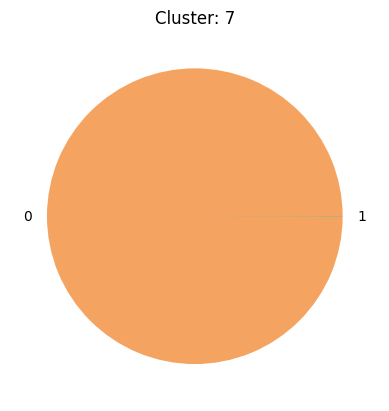

involve_killing
0    35603
1        9
Name: count, dtype: int64


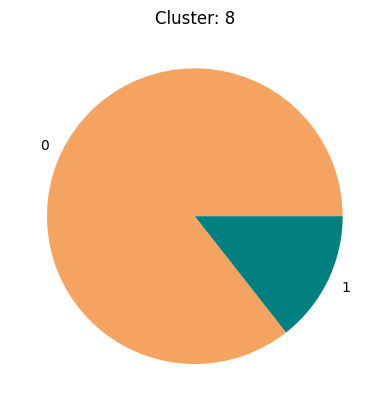

involve_killing
0    11999
1     2020
Name: count, dtype: int64


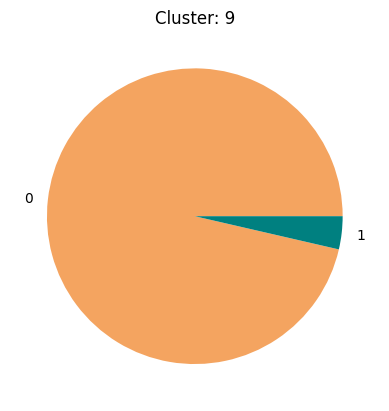

involve_killing
0    17401
1      651
Name: count, dtype: int64


In [ ]:
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}

for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[np.array(xmeans_labels) == k].value_counts()
    # Show pie plot
    labels = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)